# Analyse de données de cancer avec PCA et forêt aléatoire

Ce notebook présente une analyse de données de cancer basée sur la méthode de l'analyse en composantes principales (PCA) et le modèle de forêt aléatoire. Le but est de réduire la dimensionnalité des données et de prédire le type de cancer à partir des caractéristiques génétiques des patients.

## Importation des bibliothèques

On commence par importer les bibliothèques nécessaires pour le traitement des données, la visualisation et le machine learning.


In [1]:
%%capture
!pip install -U scikit-learn pandas
!pip install numpy
!pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

## Lecture et prétraitement des données

On lit le fichier CSV contenant les données de cancer, qui ont été préalablement téléchargées depuis le site https://www.synapse.org/#!Synapse:syn4301332. On nomme la première colonne 'patient' dans le DataFrame. On sépare les données en deux parties : les caractéristiques (X) et la cible (y). On normalise les caractéristiques pour avoir une moyenne nulle et un écart-type unitaire.

## Application de la PCA au maximum de composantes

Le but ici et de chercher pour combien de composante principale on peux obtenir 70% de la variance de l'ensemble des données.

On applique la PCA au maximum de composantes, c'est-à-dire 801, qui correspond au nombre de caractéristiques. On calcule la variance expliquée par chaque composante principale, ainsi que la variance cumulée. 
On trace un éboulis des valeurs propres, qui montre la décroissance de la variance expliquée en fonction du nombre de composantes. On ajoute une ligne verticale rouge au point où le ratio de variance expliquée atteint 0.7, ce qui correspond à environ 84 composantes principales.

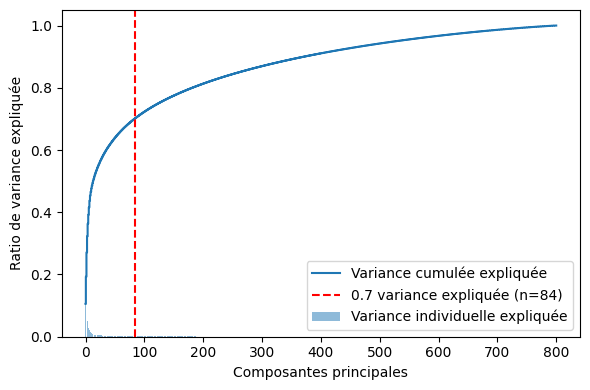

In [2]:
# Lire le fichier CSV
df = pd.read_csv('data.csv')

# Prétraitement des données
# Nommer la première colonne 'patient' dans le DataFrames
df.columns.values[0] = 'patient'

# Séparation du reste des données
y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

# Normaliser les caractéristiques
X = StandardScaler().fit_transform(X)

# Appliquer la PCA au maximum de composante
pca = PCA(n_components=801) # Vous pouvez changer le nombre de composantes
X_pca = pca.fit_transform(X)

# Calculer la variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_

# Générer les noms de colonnes pour toutes les composantes principales
column_names = [f'Composante principale {i+1}' for i in range(pca.n_components_)]

# Convertir X_pca en DataFrame avec les noms de colonnes appropriés
df_pca = pd.DataFrame(data = X_pca, columns = column_names)

# Si vous voulez ajouter les résultats à votre DataFrame original
df_final = pd.concat([df_pca, df[['patient']]], axis = 1)

# Définir l'ordre des colonnes
cols = ['patient']  + [col for col in df_final if col != 'patient']

# Réorganiser les colonnes
df_final = df_final[cols]

# Afficher les 10 premières lignes
###print(df_final.head(10))

# Calculer la variance cumulée
cumulative_variance = np.cumsum(explained_variance)

# Trouver le nombre de composantes principales nécessaires pour atteindre un ratio de variance expliqué de 0.7
num_components = np.where(cumulative_variance >= 0.7)[0][0]

# Créer un éboulis des valeurs propres
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.step(range(len(explained_variance)), cumulative_variance, where='mid', label='Variance cumulée expliquée')

# Ajouter une ligne verticale rouge au point où le ratio de variance expliquée atteint 0.7
plt.axvline(x=num_components, color='r', linestyle='--', label=f'0.7 variance expliquée (n={num_components})')

plt.ylabel('Ratio de variance expliquée')
plt.xlabel('Composantes principales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Application de la PCA avec un nombre de composantes fixé

Ensuite on applique la PCA avec un nombre de composantes fixé à 84, qui correspond au seuil de 0.7 de variance expliquée. On convertit les résultats en DataFrame et on les fusionne avec le DataFrame original.


In [3]:
# Appliquer la PCA au avec un nombre de composante = 0.7 du ratio de variance
pca = PCA(n_components=84) # Vous pouvez changer le nombre de composantes
X_pca = pca.fit_transform(X)

# Générer les noms de colonnes pour toutes les composantes principales
column_names = [f'Composante principale {i+1}' for i in range(pca.n_components_)]

# Convertir X_pca en DataFrame avec les noms de colonnes appropriés
df_pca = pd.DataFrame(data = X_pca, columns = column_names)

# Si vous voulez ajouter les résultats à votre DataFrame original
df_final = pd.concat([df_pca, df[['patient']]], axis = 1)

# Définir l'ordre des colonnes
cols = ['patient']  + [col for col in df_final if col != 'patient']

# Réorganiser les colonnes
df_final = df_final[cols]

# Afficher les 10 premières lignes si besoin
#print(df_final.head(10))

## Fusion des données avec les labels des cancers

On lit le fichier CSV contenant les labels des cancers, qui ont été préalablement téléchargés depuis le site https://www.synapse.org/#!Synapse:syn4301332. On nomme la première colonne 'patient' dans le DataFrame. On fusionne les deux DataFrames sur la colonne 'patient'. On réorganise les colonnes pour avoir la classe de cancer en première position. On utilise un objet LabelEncoder pour transformer les classes de cancer en nombres entiers. On enregistre le DataFrame réorganisé dans un nouveau fichier CSV.


In [4]:
# Lire les deux fichiers CSV
df_genes = df_final
df_cancers = pd.read_csv('labels.csv')

# Nommer la première colonne 'patient' dans les deux DataFrames
df_cancers.columns.values[0] = 'patient'

# Fusionner les deux DataFrames sur la colonne 'patient'
df_merged = pd.merge(df_genes, df_cancers, on='patient')

# Obtenir le nom de la dernière colonne
last_col_name = df_merged.columns[-1]

# Créer une nouvelle liste d'ordre de colonnes
new_order = [df_merged.columns[0], last_col_name] + list(df_merged.columns[1:-1])

# Réorganiser les colonnes
df_reordered = df_merged.reindex(columns=new_order)

# Créer un objet LabelEncoder
le = LabelEncoder()

# Utiliser LabelEncoder pour transformer les classes de cancer en nombres entiers
df_reordered['Class'] = le.fit_transform(df_reordered['Class'])

# Enregistrer le DataFrame réorganisé dans un nouveau fichier CSV
df_reordered.to_csv('reordered.csv', index=False)


## Séparation des données en ensembles d'entraînement et de test

On charge les données réorganisées à partir du fichier CSV. On sépare les données en deux parties : les caractéristiques (X) et la cible (y). On divise les données en ensembles d'entraînement et de test, avec une proportion de 0.2 pour le test et un état aléatoire fixé à 42 pour la reproductibilité.

In [5]:
# Charger les données
data = pd.read_csv('reordered.csv')

# Séparer les caractéristiques et la cible
X = data.drop(['Class','patient'], axis=1)
y = data['Class']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modèle d'arbre de décision

Dans cette partie, nous allons créer et entraîner un modèle d'arbre de décision pour prédire la classe de cancer à partir des composantes principales. Nous allons utiliser la validation croisée pour évaluer la performance du modèle, puis calculer la précision et la matrice de confusion sur l'ensemble de test.


Scores de cross-validation : [0.91358025 0.9625     0.9625     0.8875     0.9125     0.925
 0.875      0.9125     0.9375     0.9       ]
Précision de l'arbre de décision : 0.9130434782608695


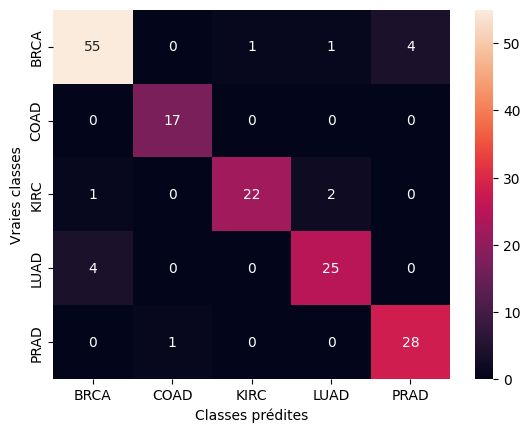

In [6]:
# Créer et entraîner un modèle d'arbre de décision
tree = DecisionTreeClassifier()

# Cross-validation
scores_t = cross_val_score(tree, X, y, cv=10)
print("Scores de cross-validation :", scores_t)

# Entrainement final tree
tree.fit(X_train, y_train)

# Prédire les classes pour l'ensemble de test
y_pred_tree = tree.predict(X_test)

# Calculer la précision de l'arbre de décision
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Précision de l\'arbre de décision : {accuracy_tree}')

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_tree)

# Définir les labels des classes
classes = ["BRCA", "COAD", "KIRC", "LUAD", "PRAD"]

# Afficher la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

# Modèle de forêt aléatoire

Dans cette partie, nous allons créer et entraîner un modèle de forêt aléatoire, qui est un ensemble d'arbres de décision. Nous allons comparer les performances de ce modèle avec celles du modèle d'arbre de décision précédent, et visualiser la matrice de confusion et la courbe d'apprentissage.

Scores de cross-validation : [0.96296296 0.975      1.         0.9875     0.95       0.9875
 1.         0.975      0.9875     0.95      ]
Précision de la forêt aléatoire : 0.9875776397515528


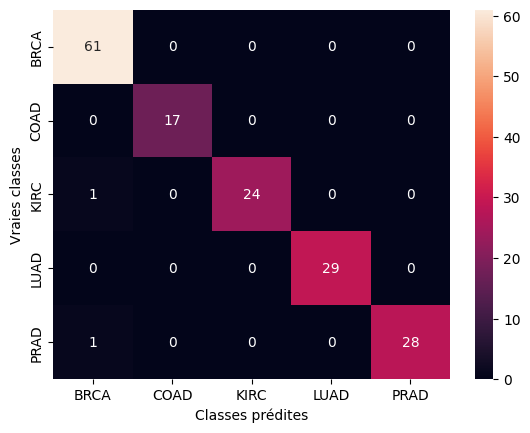

In [7]:
# Créer un modèle de forêt aléatoire
forest = RandomForestClassifier()

# Cross-validation
scores_f = cross_val_score(forest, X, y, cv=10)
print("Scores de cross-validation :", scores_f)

# Entrainement finale forest
forest.fit(X_train, y_train)

# Prédire les classes pour l'ensemble de test
y_pred_forest = forest.predict(X_test)

# Calculer la précision de la forêt aléatoire
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f'Précision de la forêt aléatoire : {accuracy_forest}')

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_forest)

# Définir les labels des classes
classes = ["BRCA", "COAD", "KIRC", "LUAD", "PRAD"]

# Afficher la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

In [8]:
## Vérification manuel de la prédiction des modèles
#choisir la ligne du patient dont on verifiera la class manuellement
patient_id = 8
patient_data = X.loc[patient_id]

# Vérifier la dimension de patient_data
if len(patient_data.shape) == 1:
    # Si patient_data est une série, la convertir en un dataframe d'une ligne
    patient_data = patient_data.to_frame().T

# Utiliser le modèle pour prédire la classe de cancer
patient_pred_tree = tree.predict(patient_data)
patient_pred_forest = forest.predict(patient_data)

print(f'Prédiction de l\'arbre de décision pour le patient {patient_id} : {patient_pred_tree[0]}')
print(f'Prédiction de la forêt aléatoire pour le patient {patient_id} : {patient_pred_forest[0]}')


Prédiction de l'arbre de décision pour le patient 8 : 0
Prédiction de la forêt aléatoire pour le patient 8 : 0


# Courbe d'apprentissage des modèles

Nous allons tracer la courbe d'apprentissage des modèles pour voir comment le score d'entraînement et le score de test évoluent en fonction de la taille de l'ensemble d'entraînement. Cela nous permettra d'évaluer si les modèles sont en situation de surapprentissage ou de sous-apprentissage.


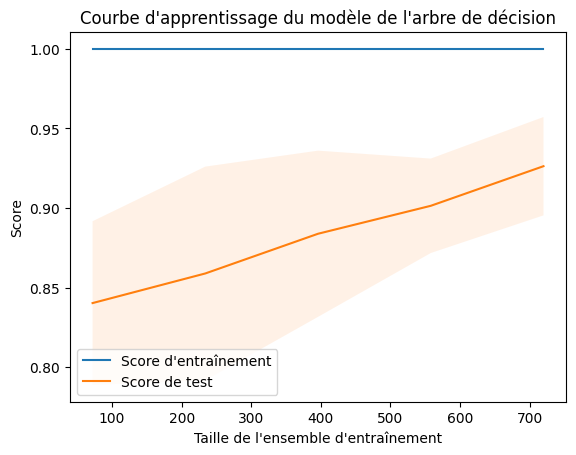

In [9]:
# Générer la courbe d'apprentissage pour le model tree
train_sizes, train_scores, test_scores = learning_curve(tree, X, y, cv=10)

# Calculer la moyenne et l'écart-type des scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.plot(train_sizes, train_mean, label="Score d'entraînement")
plt.plot(train_sizes, test_mean, label="Score de test")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Courbe d'apprentissage du modèle de l'arbre de décision")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.legend()
plt.show()

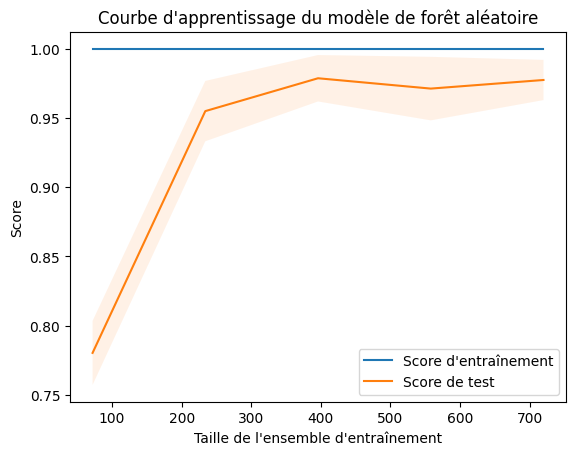

In [10]:
# Générer la courbe d'apprentissage pour le model forest
train_sizes, train_scores, test_scores = learning_curve(forest, X, y, cv=10)

# Calculer la moyenne et l'écart-type des scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.plot(train_sizes, train_mean, label="Score d'entraînement")
plt.plot(train_sizes, test_mean, label="Score de test")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Courbe d'apprentissage du modèle de forêt aléatoire")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.legend()
plt.show()

In [14]:
# Calculer la précision, le rappel, le score F1 et l'AUC-ROC pour le modèle de l'arbre de décision
precision_tree = precision_score(y_test, y_pred_tree, average='macro')
recall_tree = recall_score(y_test, y_pred_tree, average='macro')
f1_tree = f1_score(y_test, y_pred_tree, average='macro')
# Calculer l'AUC-ROC pour le modèle de l'arbre de décision
auc_tree = roc_auc_score(y_test, tree.predict_proba(X_test), multi_class='ovo')

# Afficher les résultats
print(f'Précision de l\'arbre de décision : {precision_tree}')
print(f'Rappel de l\'arbre de décision : {recall_tree}')
print(f'Score F1 de l\'arbre de décision : {f1_tree}')
print(f'AUC-ROC de l\'arbre de décision : {auc_tree}')

Précision de l'arbre de décision : 0.9170979986197377
Rappel de l'arbre de décision : 0.9218451102317694
Score F1 de l'arbre de décision : 0.9184823833055067
AUC-ROC de l'arbre de décision : 0.9511531938948558


In [15]:
# Calculer la précision, le rappel, le score F1 et l'AUC-ROC pour le modèle de la forêt aléatoire
precision_forest = precision_score(y_test, y_pred_forest, average='macro')
recall_forest = recall_score(y_test, y_pred_forest, average='macro')
f1_forest = f1_score(y_test, y_pred_forest, average='macro')
auc_forest = roc_auc_score(y_test, forest.predict_proba(X_test), multi_class='ovo')

# Afficher les résultats
print(f'Précision de la forêt aléatoire : {precision_forest}')
print(f'Rappel de la forêt aléatoire : {recall_forest}')
print(f'Score F1 de la forêt aléatoire : {f1_forest}')
print(f'AUC-ROC de la forêt aléatoire : {auc_forest}')

Précision de la forêt aléatoire : 0.9936507936507937
Rappel de la forêt aléatoire : 0.985103448275862
Score F1 de la forêt aléatoire : 0.9891837889655012
AUC-ROC de la forêt aléatoire : 0.9998196721311476
